Daily Challenge: Building a LangGraph RAG Pipeline

In [1]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00


In [2]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

In [3]:
pip install -U langchain langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.4 MB/s eta 0:00:00


In [4]:
import torch
print(f"CUDA disponible ? {torch.cuda.is_available()}")

CUDA disponible ? True


In [5]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 48.1 MB/s eta 0:00:00


In [6]:
import faiss

1.Document Loading: :

-->Charger le contenu du blog avec WebBaseLoader

In [7]:
# Load and chunk contents of the blog
url = "https://lilianweng.github.io/posts/2023-06-23-agent/"
loader = WebBaseLoader(url)
docs = loader.load()

In [8]:
# Affichage du texte extrait
# print(documents[0].page_content[:1000])  # On affiche seulement les 1000 premiers caractères

-->Configure BeautifulSoup with SoupStrainer to extract only relevant content (post title, headers, and content).

- BeautifulSoup est utilisé pour filtrer les parties utiles du document (titre, en-têtes, contenu) analyse HTML d’une page..
-SoupStrainer optimise l’extraction en sélectionnant seulement les balises pertinentes. filtre les balises utiles

In [9]:
import requests
from bs4 import BeautifulSoup, SoupStrainer

In [10]:
# Récupérer la page web
url = "https://lilianweng.github.io/posts/2023-06-23-agent/"
response = requests.get(url)

In [11]:
# On filtre uniquement les balises importantes (titre, en-têtes, contenu)
strainer = SoupStrainer(["title", "h1", "h2", "h3", "p"])
soup = BeautifulSoup(response.text, "html.parser", parse_only=strainer)

In [12]:
# Extraction des éléments filtrés
title = soup.find("title").get_text() if soup.find("title") else "No Title"
headers = [h.get_text() for h in soup.find_all(["h1", "h2", "h3"])]
paragraphs = [p.get_text() for p in soup.find_all("p")]

-->Verify that the document is loaded correctly and inspect its content.

In [13]:
# Affichage des résultats
print(f"Titre: {title}")
print(f"Headers: {headers[:5]}...\n")  # Afficher seulement les 5 premiers headers
print(f"Extrait du contenu: {' '.join(paragraphs[:3])}...\n")  # Afficher les 3 premiers paragraphes

Titre: LLM Powered Autonomous Agents | Lil'Log
Headers: ['\n      LLM Powered Autonomous Agents\n    ', 'Agent System Overview#', 'Component One: Planning#', 'Task Decomposition#', 'Self-Reflection#']...

Extrait du contenu: Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver. In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components: A complicated task usually involves many steps. An agent needs to know what they are and plan ahead....



In [14]:
docs = loader.load()
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [15]:
print(docs[0].page_content[:1000])







LLM Powered Autonomous Agents | Lil'Log







































Lil'Log

















|






Posts




Archive




Search




Tags




FAQ









      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


 


Table of Contents



Agent System Overview

Component One: Planning

Task Decomposition

Self-Reflection


Component Two: Memory

Types of Memory

Maximum Inner Product Search (MIPS)


Component Three: Tool Use

Case Studies

Scientific Discovery Agent

Generative Agents Simulation

Proof-of-Concept Examples


Challenges

Citation

References





Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.


2.Document Splitting:

-->Use RecursiveCharacterTextSplitter to split the loaded document into smaller chunks.

In [16]:
# from langchain.text_splitter import RecursiveCharacterTextSplitter7

In [17]:
# On regroupe tout le texte extrait précédemment
full_text = "\n".join(paragraphs)

In [18]:
# Configuration du text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Taille d’un chunk en caractères
    chunk_overlap=100,  # Chevauchement entre chunks
    add_start_index=True  # Suivi de la position d'origine
)

In [19]:
# Découpage du texte en morceaux
chunks = text_splitter.create_documents([full_text])

In [20]:
len(chunks)

63

In [21]:
# Vérification du nombre de chunks créés
print(f" Nombre de chunks créés : {len(chunks)}")
print(f"Extrait du premier chunk :\n{chunks[0].page_content}")

 Nombre de chunks créés : 63
Extrait du premier chunk :
Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:


3.Vector Store Indexing:

In [22]:
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings

- modèle d'embedding: OpenAI, Sentence Transformers
- un vector store: AISS, ChromaDB..

OpenAIEmbeddings() est un modèle d’embedding fourni par OpenAI: - Comprendre le sens -Générer des vecteurs de haute qualité - compatible avec LangChain et FAISS

 -->pour éviter d’utiliser OpenAI (qui nécessite une clé API), tu peux utiliser Sentence Transformers (HuggingFaceEmbeddings) :

In [23]:
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

In [42]:
# Étape 1 : Charger le modèle d’embedding Hugging Face
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2", model_kwargs={"device": "cuda"})

In [25]:
# Étape 2 : Convertir les chunks en embeddings et les stocker dans FAISS
vector_store = FAISS.from_documents(chunks, embedding_model)

# Étape 3 : Vérification du nombre de documents indexés
print(f" Nombre de documents indexés : {len(chunks)}")

 Nombre de documents indexés : 63


In [26]:
len(chunks)

63

4.LangGraph Pipeline Setup:

In [27]:
from typing import TypedDict
from langchain.schema import Document

--> Définir l’état de l’application (TypedDict)

In [28]:
# Définition de l'état du pipeline RAG
class RAGState(TypedDict):
    question: str # question posée par l’utilisateur.
    context: list[Document] # documents récupérés du store de vecteurs
    answer: str # la réponse générée par le modèle de langage.

--> Définir la fonction retrieve() pour la recherche de similarité

In [29]:
def retrieve(state: RAGState) -> RAGState:
    """Effectue une recherche de similarité dans le store de vecteurs."""
    retrieved_docs = vector_store.similarity_search(state["question"], k=3)  # Récupère 3 chunks les plus proches
    return {**state, "context": retrieved_docs}

--> Définir la fonction generate() pour formater le prompt et générer la réponse

In [30]:
from langchain.llms import HuggingFacePipeline
from langchain.hub import pull

In [31]:
# Chargement du template de prompt depuis LangChain Hub
prompt_template = pull("rlm/rag-prompt")

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [32]:
from transformers import pipeline

In [ ]:
# Charger le modèle avec une meilleure configuration
llm_pipeline = pipeline(
    "text-generation",
    model="tiiuae/falcon-7b-instruct",
    max_new_tokens=200,  # Permet une génération plus longue
    pad_token_id=50256   # Évite le warning
)

model-00001-of-00002.safetensors:  39%|###8      | 3.86G/9.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
llm = HuggingFacePipeline(pipeline=llm_pipeline)

In [38]:
# # Chargement du modèle de génération de texte
# llm = HuggingFacePipeline.from_model_id(model_id="tiiuae/falcon-7b-instruct", task="text-generation")


tokenizer_config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [69]:
def generate(state: RAGState) -> RAGState:
    """Formate le prompt et génère une réponse."""
    context_text = "\n".join([doc.page_content for doc in state["context"]])

    # Construction du prompt avec le template RAG
    prompt = prompt_template.format(context=context_text, question=state["question"])

    # Génération de la réponse avec .predict() au lieu de .invoke()
    response = llm.predict(prompt)

    return {**state, "answer": response}

--> Construction du pipeline LangGraph

In [50]:
pip install langgraph

In [51]:
from langgraph.graph import StateGraph

In [70]:
from langgraph.graph import StateGraph

# Création du graphe avec l'état défini précédemment
graph = StateGraph(RAGState)

# Ajout des nœuds
graph.add_node("retrieve", retrieve)
graph.add_node("generate", generate)

# Connexion des étapes
graph.set_entry_point("retrieve")  # Point de départ du pipeline
graph.add_edge("retrieve", "generate")  # Relie retrieve → generate

# Compilation du graphe
graph = graph.compile()

In [71]:
mermaid_code = graph.get_graph().draw_mermaid()
print(mermaid_code)

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	retrieve(retrieve)
	generate([generate]):::last
	__start__ --> retrieve;
	retrieve --> generate;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [72]:
from IPython.display import display

graph_img = graph.get_graph().draw_mermaid_png()
display(graph_img)  # Ceci affichera l'image du graphe

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00j\x00\x00\x00\xea\x08\x02\x00\x00\x00\xc5\xf3G\x18\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x19-IDATx\x9c\xed\x9d{\\\x14U\xff\xc7\xcf\xec\xec\xfd\xc6\xb2,\xa0\xdco\x99\t\xa8\x80\n\xa2\t\x06\x86\x8ahF\x89\xdaC\xf5XO\xfa\x98\x96\xa9\xbf\xd4J\xd3\xea\xa9\x9e\xcaWV^\xb3\x12\xed\xa2i\x8f\xb7\xccT\xf2\x96\xa0\xa8\x88\xa1x\x05\xb9\xb3\xbb\\\xf6\xc2\xdewgf\xf7\xf9c\xfd\xad<\xb9\xbb\xb30\xbb2\xd0\xbc\xffZ\xe6\x9c3\xf3\x9d\x0f3\xe7\x9c\xf9\x9e\xef9\x07\xb2\xd9l\x80\xa2\xa7\xd0z\xdb\x80\xbe\r%\x1f!(\xf9\x08A\xc9G\x08J>BP\xf2\x11\x82N\xb0\xbcV\x89t*\x10\x83\x163h0\x14\xb1Y\xad}\xa0\x1b\xc4d\xd3X\x1c\x1aW\x00\xf3\xfc\xe8\x92\x10\x16\x91SA=\xeb\xf7)d\xe6;W\xf4uW\xf5L.\x04l\x10W\x00s\x850\x87G\xb7b}@>\x1a\x0c\xd4\xed\x88A\x8b\xb1\xb94i\xad):\x81\x17\x9b\xc8\x0b\x1b\xc4\xed\xc1\xa9\xba-\x9fN\x8d\x9e\xfd\xb9\xc3\x06\x80H\xc2\x88N\xe4\x05\x85\xb1{pU\xf2\xa0U!uU\xfa\xb6f\xb3\xba\x15\x19\x9d\x17\x10\x1a\xcb\xe9V\xf1\xee\xc9w\xf1\x98\xb2\xealgz\x9e\xe

In [73]:
from IPython.display import display, Markdown

mermaid_code = graph.get_graph().draw_mermaid()
display(Markdown(f"```mermaid\n{mermaid_code}\n```"))

```mermaid
%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	retrieve(retrieve)
	generate([generate]):::last
	__start__ --> retrieve;
	retrieve --> generate;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc

```

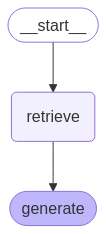

In [74]:
from IPython.display import Image, display

# Générer une image PNG du graphe
png_data = graph.get_graph().draw_mermaid_png()
display(Image(png_data))

5.Pipeline Execution:

In [76]:
# Exemple de question utilisateur
user_question = "Quels sont les principes des agents en IA ?"

# Lancer l'exécution du pipeline avec la question
result = graph.invoke({"question": user_question})

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ValueError: Input length of input_ids is 233, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.